In [1]:
import xarray as xr
import os
from geopy.distance import distance
import numpy as np
import matplotlib.pyplot as plt

In [10]:
from CTH_helper import scan_directory_for_files 
BT_dir = scan_directory_for_files('/projekt_agmwend/data/EUREC4A/06_Flights/', 'v0.3.nc', keywords='Filter_05')

BT_05 = [xr.open_dataset(file) for file in BT_dir if 'HALO_VELOX_BT_Filter_05' in file]

VELOX_time = xr.concat([BT.time for BT in BT_05], dim='time').sortby('time')
VELOX_time['lat'] = xr.concat([BT.lat for BT in BT_05], dim='time').sortby('time')
VELOX_time['lon'] = xr.concat([BT.lon for BT in BT_05], dim='time').sortby('time')


478it [02:45,  2.90it/s]


In [11]:
track_files = [os.path.join(file) for file in os.scandir('/home/jomueller/VELOX_CTH/data/tracks/EUREC4A_tracks_v1.0')]

In [12]:
selected_platforms = ['Meteor', 'RonBrown', 'MS-Merian']

#selected_files = [file for file in track_files if any([platform in selected_platforms]
selected_files = [file for file in track_files if any(platform in file for platform in selected_platforms)]


In [13]:
vessel_track_list = [xr.open_dataset(file) for file in selected_files]
halo_track = xr.open_dataset('/home/jomueller/VELOX_CTH/data/tracks/EUREC4A_tracks_v1.0/EUREC4A_tracks_HALO_v1.0.nc')
halo_track = halo_track.dropna(dim='time')

names = [dataset.attrs['platform'] for dataset in vessel_track_list]


In [14]:
def search_overpass(ds_halo, ds_vessel):

    # !!!!!!!!!!!!!!!
    # Drop any data points where the latitude or longitude is NaN
    # use the argument drop=True to drop the en
    # tire time step if any of the lat/lon values are NaN

    ds_vessel = ds_vessel.where(~np.isnan(ds_vessel.lat) & ~np.isnan(ds_vessel.lon), drop=True)

    # Identify the time range where both the aircraft and ship data are available
    tmin, tmax = max([min(ds_halo.time.values), min(ds_vessel.time.values)]), min([max(ds_vessel.time.values), max(ds_halo.time.values)])
    common_time_range = slice(tmin, tmax)
    
    aircraft_common = ds_halo.sel(time=common_time_range)
    ship_common = ds_vessel.sel(time=common_time_range)

    aircraft_interp = aircraft_common#.interp_like(ship_common.time)
    ship_interp = ship_common.interp_like(aircraft_common.time).fillna(0)

    # Calculate the distance between the aircraft and ship at each time interval
    relative_pos_HALO_METEOR = np.array([distance((y1, x1),(y2, x2)).km for (y1, x1, y2, x2) in zip(aircraft_interp.lat.values, aircraft_interp.lon.values, ship_interp.lat.values, ship_interp.lon.values)])
    output = xr.DataArray(relative_pos_HALO_METEOR, dims=['time'], coords={'time':aircraft_common.time})
    output = output.dropna('time')

    return output

In [15]:
overpass_dists = [search_overpass(VELOX_time, vessel_track.dropna(dim='time')) for vessel_track in vessel_track_list]

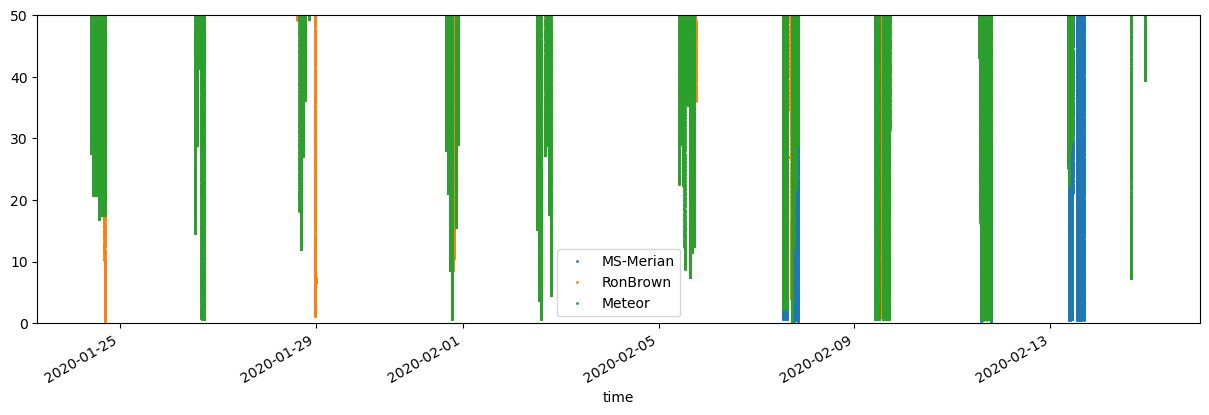

In [16]:
fig, ax = plt.subplots(figsize =(15, 4))

for overpass, name in zip(overpass_dists, names):
    overpass.plot(ax=ax, label=name, marker='o', markersize=1, linewidth=0)
    ax.set_ylim(0, 50)
plt.legend()


In [246]:
overpass_dict = {}

for overpass, name in zip(overpass_dists, names):
    match = overpass < 1
    datetimes = overpass.isel(time=match).time

    if len(datetimes) != 0:
        hourly_first = datetimes.groupby('time.hour').first('time')
        overpass_dict[name] = hourly_first
    #print(names[i], hourly_first)


In [247]:
overpass_dict

{'MS-Merian': <xarray.DataArray 'time' (hour: 12)>
 array(['2020-02-13T08:55:46.000000000', '2020-02-13T09:51:58.000000000',
        '2020-02-13T10:48:55.000000000', '2020-02-07T12:59:19.000000000',
        '2020-02-07T13:54:52.000000000', '2020-02-07T14:50:25.000000000',
        '2020-02-13T15:13:11.000000000', '2020-02-13T16:15:37.000000000',
        '2020-02-07T17:23:52.000000000', '2020-02-07T18:24:53.000000000',
        '2020-02-07T19:23:40.000000000', '2020-02-07T20:22:14.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
   * hour     (hour) int64 8 9 10 12 13 14 15 16 17 18 19 20
 Attributes:
     long_name:  time,
 'RonBrown': <xarray.DataArray 'time' (hour: 1)>
 array(['2020-01-24T16:31:33.000000000'], dtype='datetime64[ns]')
 Coordinates:
   * hour     (hour) int64 16
 Attributes:
     long_name:  time,
 'Meteor': <xarray.DataArray 'time' (hour: 9)>
 array(['2020-02-09T10:13:27.000000000', '2020-02-09T11:11:07.000000000',
        '2020-02-09T12:08:54.000000000', '2020

In [19]:
xr.open_dataset('/home/jomueller/VELOX_CTH/data/EUREC4A_Meteor_surface_heat_fluxes_20200115_v1.0.nc')

<xarray.Dataset>
Dimensions:                      (time: 2016, nbnds: 2)
Coordinates:
  * time                         (time) datetime64[ns] 2020-01-15 ... 2020-02...
Dimensions without coordinates: nbnds
Data variables: (12/41)
    lat                          (time) float32 ...
    lon                          (time) float32 ...
    time_bnds                    (time, nbnds) datetime64[ns] ...
    SHF_EC_mast                  (time) float32 ...
    SHF_bulk_mast                (time) float32 ...
    LHF_EC_mast                  (time) float32 ...
    ...                           ...
    mask_despiking_T_mast        (time) float32 ...
    mask_despiking_Z_mast        (time) float32 ...
    mask_data_availability_mast  (time) float32 ...
    mask_vsea_bulk_mast          (time) float32 ...
    mask_vsea_bulk_bow           (time) float32 ...
    mask_LHF_EC_bow_transit      (time) float32 ...
Attributes:
    title:           Eddy-Covariance and bulk turbulent surface fluxes averag...
    history:         Created 21-09-21
    institution:     Meteorological Institute, Universitaet Hamburg
    contact_person:  Imke Schirmacher (imke.schirmacher@uni-koeln.de), Ingo L...
    source:          Ultra-Sonic Anemometer/Thermometer METEK uSonic-3 Scient...
    comments:        The surface fluxes are processed and flagged (nan) by th...
    authors:         Schirmacher, Imke; Lange, Ingo

In [265]:
def velox_tb_histogram(datetime, channel):

    date_index = datetime.dt.strftime('%m%d').item()

    BT_path = f'/projekt_agmwend/data/EUREC4A/06_Flights/Flight_2020{date_index}a/VELOX/VELOX_327kveL/EUREC4A_HALO_VELOX_BT_Filter_0{channel}_2020{date_index}_v0.3.nc'
    CM_path = f'/projekt_agmwend/data/EUREC4A/06_Flights/Flight_2020{date_index}a/VELOX/VELOX_327kveL/EUREC4A_HALO_VELOX_cloudmask_2020{date_index}_v4.1.nc'
    xr_cloudmask = xr.open_dataset(CM_path)
    xr_velox = xr.open_dataset(BT_path)
    t_a = (datetime.values - np.timedelta64(1, 's'))
    t_e = (datetime.values + np.timedelta64(1, 's'))

    overpass_slice = xr_cloudmask.sel(time=slice(t_a, t_e))
    min_cloudy_scene = overpass_slice.where(overpass_slice['CF_min'] == overpass_slice['CF_min'].min(), drop=True).isel(time=0)
    BT = xr_velox['BT_2D'].sel(time=min_cloudy_scene.time, method='nearest').where(min_cloudy_scene.cloud_mask < 1)

    #counts, bin_edges = np.histogram(BT.values.flatten(), bins=100)
    #bins = (bin_edges[1:] + bin_edges[:-1])/2
    #xr_velox.close()
    #xr_cloudmask.close()
    
    return BT

In [253]:
overpass_dict['Meteor']

<xarray.DataArray 'time' (hour: 9)>
array(['2020-02-09T10:13:27.000000000', '2020-02-09T11:11:07.000000000',
       '2020-02-09T12:08:54.000000000', '2020-02-11T13:47:16.000000000',
       '2020-02-02T14:13:25.000000000', '2020-01-26T15:51:53.000000000',
       '2020-01-26T16:23:34.000000000', '2020-01-26T17:09:40.000000000',
       '2020-01-31T18:43:33.000000000'], dtype='datetime64[ns]')
Coordinates:
  * hour     (hour) int64 10 11 12 13 14 15 16 17 18
Attributes:
    long_name:  time

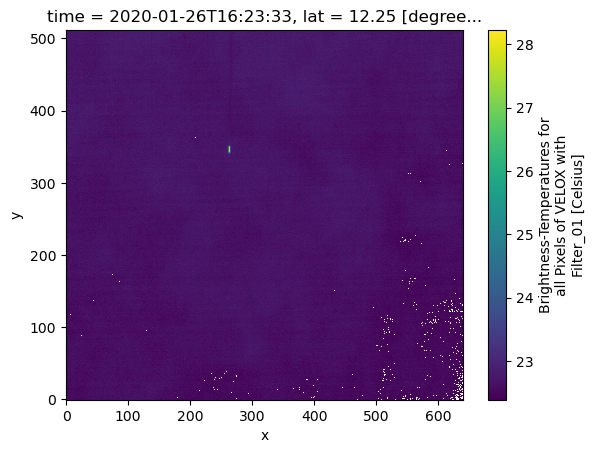

In [270]:
test = velox_tb_histogram(overpass_dict['Meteor'][6], channel=1)
test.plot()

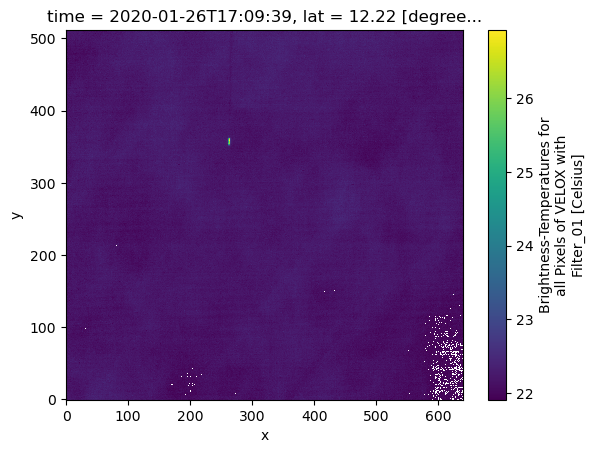

In [269]:
test = velox_tb_histogram(overpass_dict['Meteor'][7], channel=1)
test.plot()

In [273]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))

for intersect_date, ax in zip(overpass_dict['MS-Merian'], axs.flatten()):
    test = velox_tb_histogram(isntersect_date, channel=1)
    test.plot(ax=ax)

AttributeError: 'Rectangle' object has no property 'robust'

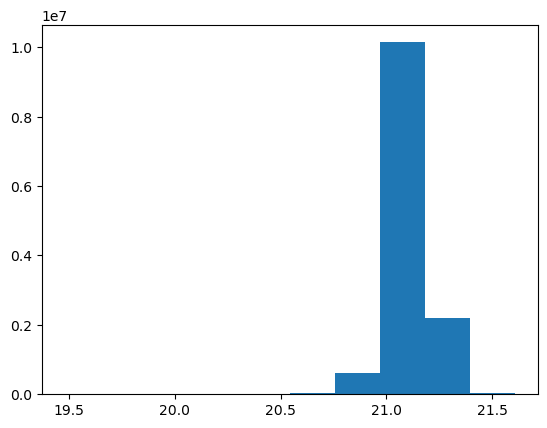

In [249]:
test = velox_tb_histogram(overpass_dict['Meteor'][-1], channel=1)
test.plot(robust=True)

In [22]:
import scipy
import pandas as pd
data = scipy.io.loadmat('/home/jomueller/VELOX_CTH/data/msm_089_1_dship_20200118_20200220_1min.mat')

rows = data['head'][0][0]
dataVal = data['dat'][0][0]
data_dict = {}

for i in range(len(rows)):
    data_dict[rows[i].item()] = dataVal[i].flatten()

pd_merian = pd.DataFrame(data_dict)
pd_merian['date time'] = [item.item() for item in pd_merian['date time'].squeeze()]

pd_merian['time'] = pd.to_datetime(pd_merian['date time'], format="%Y/%m/%d %H:%M:%S")
pd_merian = pd_merian.set_index('time')
pd_merian = pd_merian.drop(columns=['date time'])
xr_merian = pd_merian.to_xarray()
xr_merian = xr_merian.rename({'Latitude' : 'lat', 'Longitude' : 'lon'})

In [23]:
histograms_channel_6 = []
histograms_channel_3 = []
time_list = []

for overpass in overpass_dict['MS-Merian']:
    histograms_channel_3.append(velox_tb_histogram(overpass, 3))
    histograms_channel_6.append(velox_tb_histogram(overpass, 6))
    time_list.append(overpass)

In [24]:
from scipy.signal import find_peaks

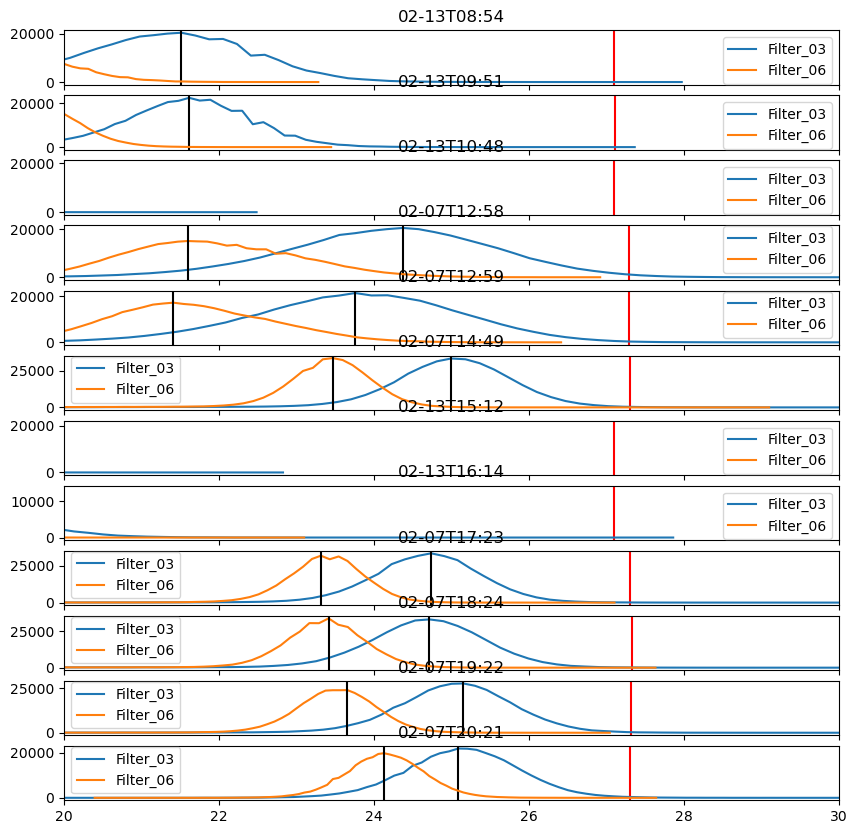

In [29]:
fig, axs = plt.subplots(len(histograms_channel_3), figsize=(10, 10), sharex=True)

channel_3_peak = []
channel_6_peak = []
merian_peak = []

for ax, data03, data06, time in zip(axs, histograms_channel_3, histograms_channel_6, time_list):
    t_a = (time.values - np.timedelta64(30, 'm'))
    t_e = (time.values + np.timedelta64(30, 'm'))

    time_slice = slice(t_a, t_e)

    SST_merian = xr_merian.sel(time=time_slice)['Weatherstation.PEUMA.Water_temperature'].mean()
    merian_peak.append(SST_merian)

    ax.axvline(SST_merian, color='r')

    for BT, channel_list in zip([data03, data06], [channel_3_peak, channel_6_peak]):
        name = BT.long_name.split(' ')[-1]
        counts, bin_edges = np.histogram(BT.values.flatten(), bins=250, range=(20,30))
        bins = (bin_edges[1:] + bin_edges[:-1])/2

        peak, peak_prop = find_peaks(counts, prominence=10000)
        channel_list.append(bins[peak])

        ax.plot(bins, counts, label = name)
        ax.axvline(bins[peak], color='k')
        title = BT.time.dt.strftime('%m-%dT%H:%M').item()
        ax.set_title(title)
        ax.legend()
        ax.set_xlim(20, 30)
plt.legend()

In [168]:
mask = (np.array(channel_3_peak)) > 23
mask = mask.squeeze()

In [169]:
channel_3_peak

[array([21.512909], dtype=float32),
 array([21.613194], dtype=float32),
 array([11.663448], dtype=float32),
 array([24.370657], dtype=float32),
 array([23.756184], dtype=float32),
 array([24.99419], dtype=float32),
 array([13.45918], dtype=float32),
 array([15.792273], dtype=float32),
 array([24.735882], dtype=float32),
 array([24.712955], dtype=float32),
 array([25.151276], dtype=float32),
 array([25.085789], dtype=float32)]

In [218]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

B11 = np.array(channel_3_peak)
B12 = np.array(channel_6_peak)

BTD = B11 - B12

X = np.stack([B11[mask], BTD[mask]])[:,:,0].T
Y = np.array([peak.values.item() for peak in merian_peak])[mask]

In [219]:
LinearRegression().fit(X, Y).coef_

array([ 0.00595992, -0.01403735], dtype=float32)

In [221]:
import numpy as np
from scipy.optimize import curve_fit

# Define the linear model function
def linear_model(X, *coef):
    return X @ coef

# Generate some example data
# Set bounds for the coefficients

# Set an initial guess for the coefficients
coef_init = np.array([0.9, 0.1])

# Perform linear regression with coefficient bounds
coefficients, _ = curve_fit(linear_model, X, Y, p0=coef_init)

# Calculate the intercept
intercept = y.mean() - X.mean(axis=0) @ coefficients

print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [1.06360011 0.61599604]
Intercept: -19.29780426321555


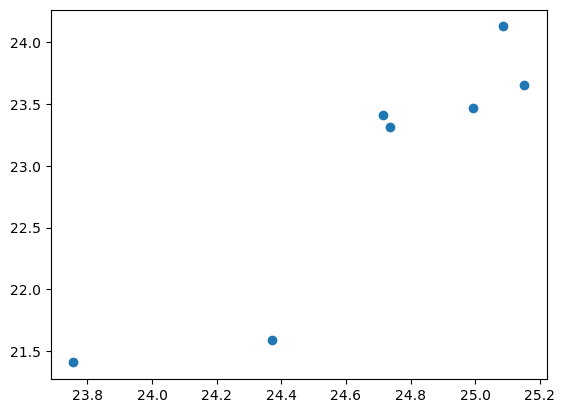

In [222]:
plt.scatter(B11[mask], B12[mask])

In [98]:
model.coef_, model.intercept_

(array([ 0.0034255, -0.0048074], dtype=float32), 27.236761)

In [ ]:
BT_03 = np.array(channel_3_peak).flatten()
BT_06 = np.array(channel_6_peak).flatten()
BTD_0306 = BT_03 - BT_06



In [ ]:
pd_merian['date time'].values.reshape(-1)

array([array(['2020/01/18 16:00:00'], dtype='<U19'),
       array(['2020/01/18 16:01:00'], dtype='<U19'),
       array(['2020/01/18 16:02:00'], dtype='<U19'), ...,
       array(['2020/02/20 00:42:00'], dtype='<U19'),
       array(['2020/02/20 00:43:00'], dtype='<U19'),
       array(['2020/02/20 00:44:00'], dtype='<U19')], dtype=object)

In [ ]:
import scipy
import pandas as pd
data = scipy.io.loadmat('/home/jomueller/VELOX_CTH/data/msm_089_1_dship_20200118_20200220_1min.mat')

rows = data['head'][0][0]
dataVal = data['dat'][0][0]
data_dict = {}

for i in range(len(rows)):
    data_dict[rows[i].item()] = dataVal[i].flatten()

pd_merian = pd.DataFrame(data_dict)
pd_merian['date time'] = [item.item() for item in pd_merian['date time'].squeeze()]

pd_merian['time'] = pd.to_datetime(pd_merian['date time'], format="%Y/%m/%d %H:%M:%S")
pd_merian = pd_merian.set_index('time')
pd_merian = pd_merian.drop(columns=['date time'])
xr_merian = pd_merian.to_xarray()
xr_merian = xr_merian.rename({'Latitude' : 'lat', 'Longitude' : 'lon'})



In [ ]:
xr_merian

<xarray.Dataset>
Dimensions:                                       (time: 46605)
Coordinates:
  * time                                          (time) datetime64[ns] 2020-...
Data variables: (12/171)
    Matlab datenum                                (time) float64 7.378e+05 .....
    lat                                           (time) float64 13.43 ... 13.08
    lon                                           (time) float64 -58.79 ... -...
    Waterdepth                                    (time) float64 2.695e+03 .....
    Heading                                       (time) float64 65.1 ... 89.8
    SYS.CALC.BearingNextWaypoint                  (time) float64 99.4 ... nan
    ...                                            ...
    SYS.CALC.AbsoluteWind_kn                      (time) float64 20.2 ... 17.3
    SYS.CALC.RelativeWind_kn                      (time) float64 29.2 ... 17.3
    Global_radiation.SMSMN.GS                     (time) float64 1.439e+03 .....
    Global_radiation.SMSMN.IR                     (time) float64 192.0 ... nan
    Global_radiation.SMSMN.PA                     (time) float64 2.307e+03 .....
    Global_radiation.SMSMN.TI                     (time) float64 28.7 ... nan

In [ ]:


for time in overpass_dict['MS-Merian']:
    t_a = (time.values - np.timedelta64(30, 'm'))
    t_e = (time.values + np.timedelta64(30, 'm'))

    time_slice = slice(t_a, t_e)

    print(xr_merian.sel(time=time_slice)['Weatherstation.PEUMA.Water_temperature'].mean())

<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.10166667)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.10333333)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.1)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.285)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.275)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.29833333)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.10166667)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.10166667)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.30166667)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.32333333)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.31166667)
<xarray.DataArray 'Weatherstation.PEUMA.Water_temperature' ()>
array(27.305)


In [ ]:
xr_merian['RSWS.RSMC1.MC1ti'].sel(time=overpass_dict['MS-Merian'], method='nearest')

<xarray.DataArray 'RSWS.RSMC1.MC1ti' (hour: 12)>
array([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan, 28.875, 28.785, 28.774])
Coordinates:
    time     (hour) datetime64[ns] 2020-02-13T08:56:00 ... 2020-02-07T20:22:00
  * hour     (hour) int64 8 9 10 12 13 14 15 16 17 18 19 20

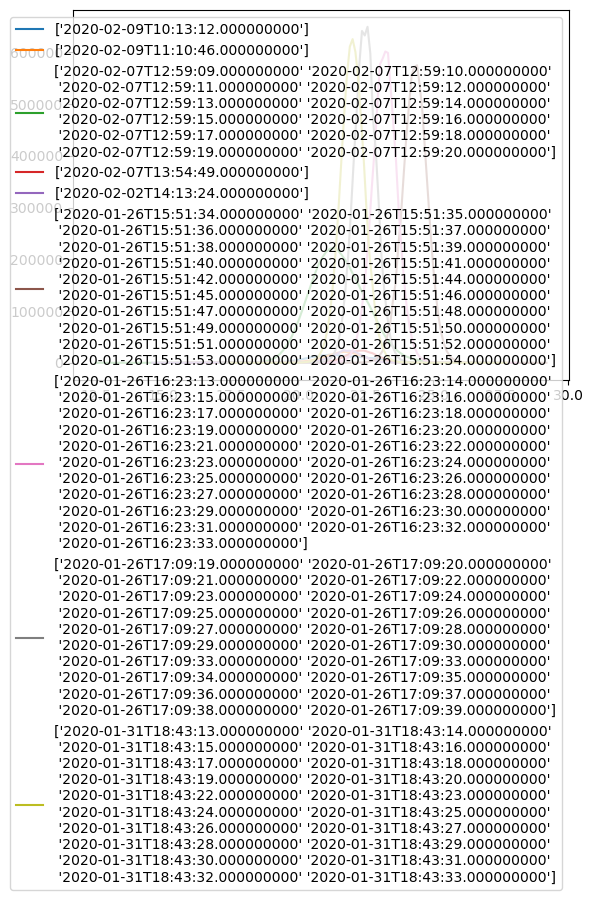

In [ ]:
for data03, data06 in zip(histograms_channel_3, histograms_channel_6):
    for BT in [data03, data06]:
        counts, bin_edges = np.histogram(BT.values.flatten(), bins=100)
        bins = (bin_edges[1:] + bin_edges[:-1])/2
    plt.plot(bins, counts, label=BT.time.values)
plt.legend()


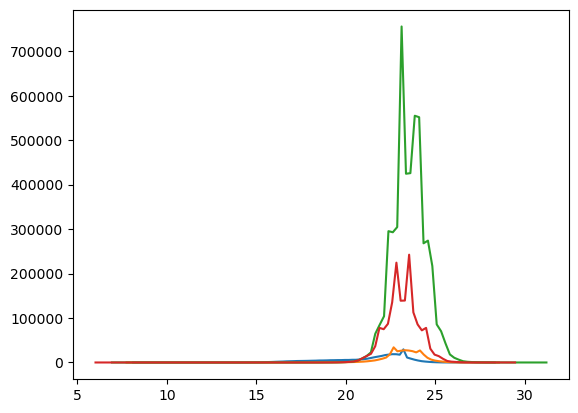

In [ ]:
for bt_03, bt_06 in zip(histograms_channel_3, histograms_channel_6):
    plt.plot(bt_03[1], bt_03[0])

In [ ]:
overpass_dict.keys()

dict_keys(['SD-1064', 'Meteor'])